In [2]:
# the default directory is the "notebooks" folder; set it one level up.
setwd("..")

In [3]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [4]:
library(readr)
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)
library(ggthemes)
library(ggpubr)
library(ComplexUpset)

## Read in `sourmash taxonomy` results

In [5]:
read_gather <- function(path){
  gather <- read_csv(path, col_types = "ddddddddcccddddcccdc")
}

In [6]:
sourmash_taxonomy <- Sys.glob("outputs/sourmash_taxonomy/*k31*csv") %>%
  map_dfr(read_gather) %>% # read in files
  separate(lineage, into = c("kingdom", "phylum", "class", "order", "family", "genus", "species", "strain"),
           sep = ";", remove = F, fill = "right") %>% # separate lineage column into commensurate parts
  mutate(database = basename(filename),
         database = gsub("genbank-2022.03-", "", database),
         database = gsub("-k31.zip", "", database))

## Sample composition overview

#### How many total genomes (strains) were detected in each metagenome?

In [7]:
sourmash_taxonomy %>%
  group_by(query_name) %>%
  tally()

query_name,n
<chr>,<int>
SRR19888423,796
SRR19888427,827
SRR19888432,970
SRR19888434,1034
SRR19888438,773
SRR19888440,950


#### How many total species were detected in each metagenome?

In [8]:
sourmash_taxonomy %>%
  select(lineage, query_name) %>%
  distinct() %>%
  group_by(query_name) %>%
  tally()

query_name,n
<chr>,<int>
SRR19888423,652
SRR19888427,634
SRR19888432,833
SRR19888434,853
SRR19888438,626
SRR19888440,736


#### How many total genomes (strains) were detected among the metagenomes for each of the five lineages bacteria, archaea, viral, protozoa, fungi?

In [9]:
sourmash_taxonomy %>%
  group_by(database, query_name) %>%
  tally()

database,query_name,n
<chr>,<chr>,<int>
archaea,SRR19888432,2
archaea,SRR19888434,1
archaea,SRR19888440,2
bacteria,SRR19888423,787
bacteria,SRR19888427,810
bacteria,SRR19888432,958
bacteria,SRR19888434,1016
bacteria,SRR19888438,761
bacteria,SRR19888440,927


**How many distinct lineages were observed across all samples?**

In [11]:
sourmash_taxonomy %>%
  select(lineage) %>%
  distinct() %>%
  nrow()

[1] 1725

## plot something

In [12]:
bacteria_plot <- ggplot(sourmash_taxonomy %>% filter(database == "bacteria"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 20")

fungi_plot <- ggplot(sourmash_taxonomy %>% filter(database == "fungi"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Set1")

viral_plot <- ggplot(sourmash_taxonomy %>% filter(database == "viral"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Set2")

protozoa_plot <- ggplot(sourmash_taxonomy %>% filter(database == "protozoa"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Dark2")

archaea_plot <- ggplot(sourmash_taxonomy %>% filter(database == "archaea"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 10")

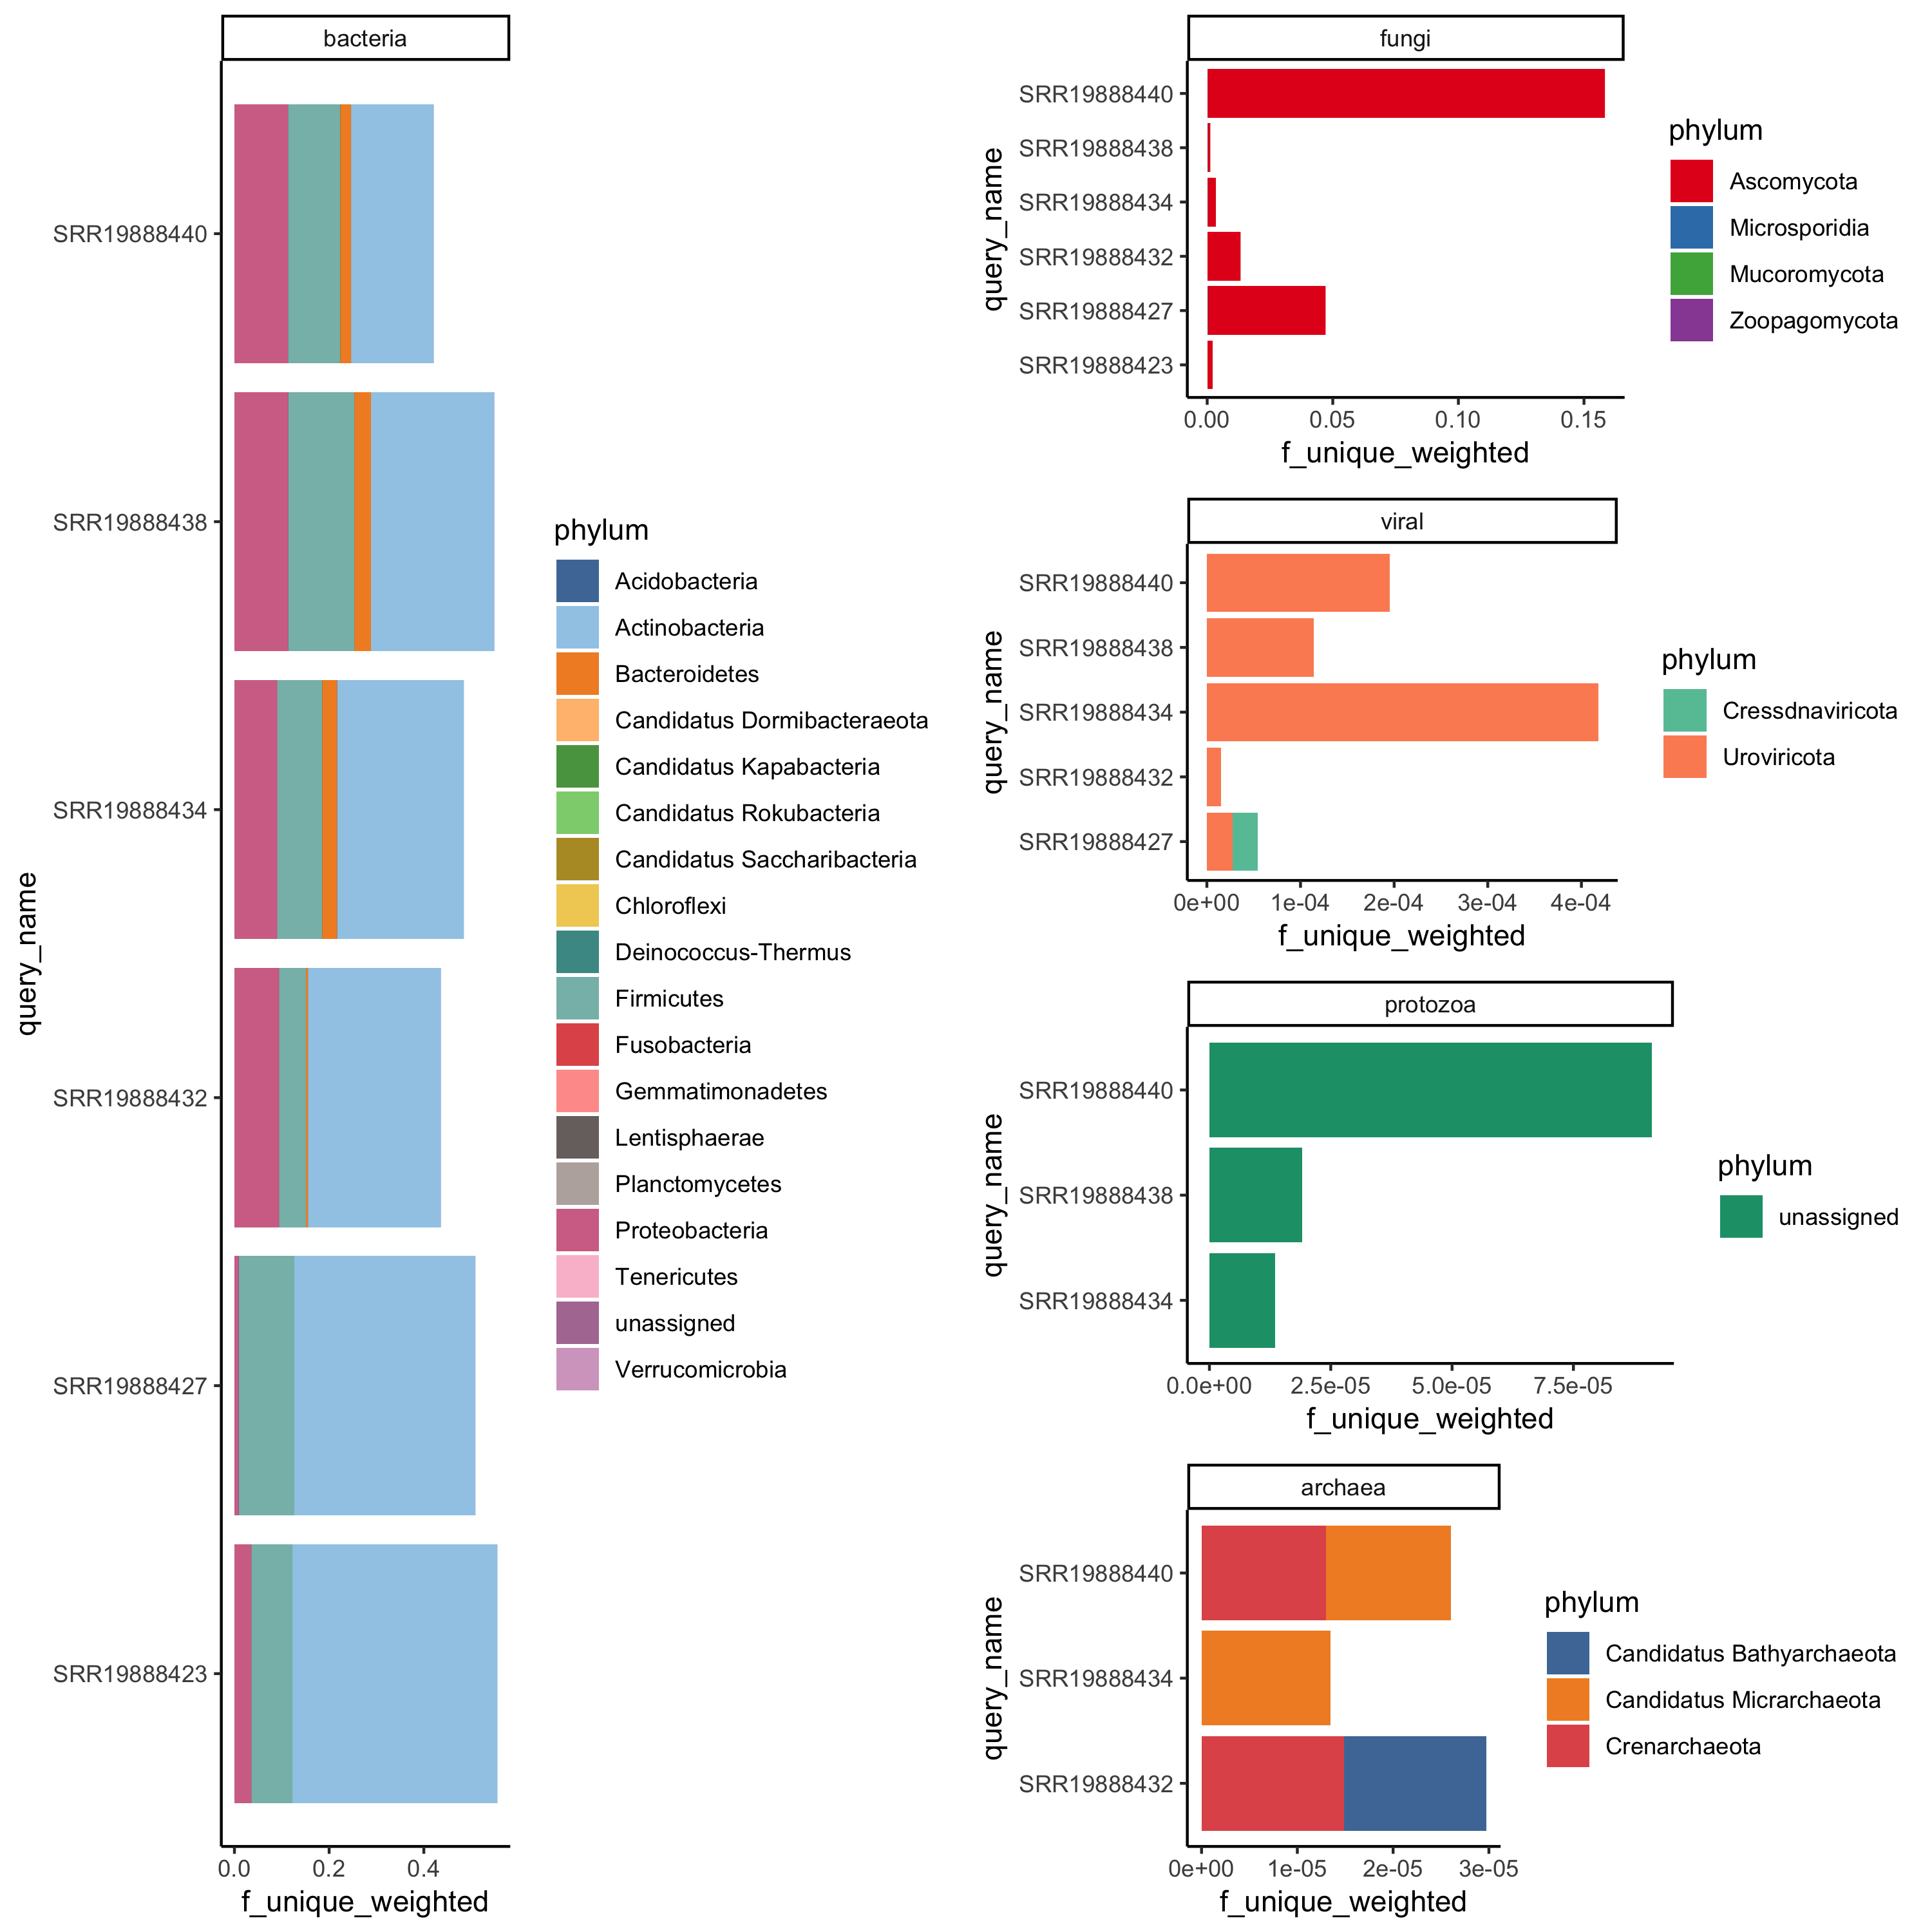

In [13]:
ggarrange(bacteria_plot, 
          ggarrange(fungi_plot, viral_plot, protozoa_plot, archaea_plot, nrow =4, ncol = 1), ncol = 2)

## Upset plot of shared lineages observed between samples

The below upset plot shows the number of shared lineages between samples. 
These are full lineages, which may be represented up to the strain level.

In [18]:
# re-read in taxonomy results in list format instead of parsing from the above data
files <- Sys.glob("outputs/sourmash_taxonomy/*k31*csv") # list files in the taxonomy folder that contain k31 and end with .csv
sourmash_taxonomy_list <- list()
for(i in 1:length(files)){
    taxonomy <- read_csv(files[i], show_col_types = F) # read in the sourmash taxonomy results
    taxonomy_name <- unique(taxonomy$query_name)       # record the signature name which is currently stored as the column name
    sourmash_taxonomy_list[[i]] <- taxonomy$name       # record the lineage names in a list
    names(sourmash_taxonomy_list)[i] <- taxonomy_name  # set the name of the list index to the signature name
}

In [21]:
# re-format the list into format needed to make upset plot
upset_list <- UpSetR::fromList(sourmash_taxonomy_list)

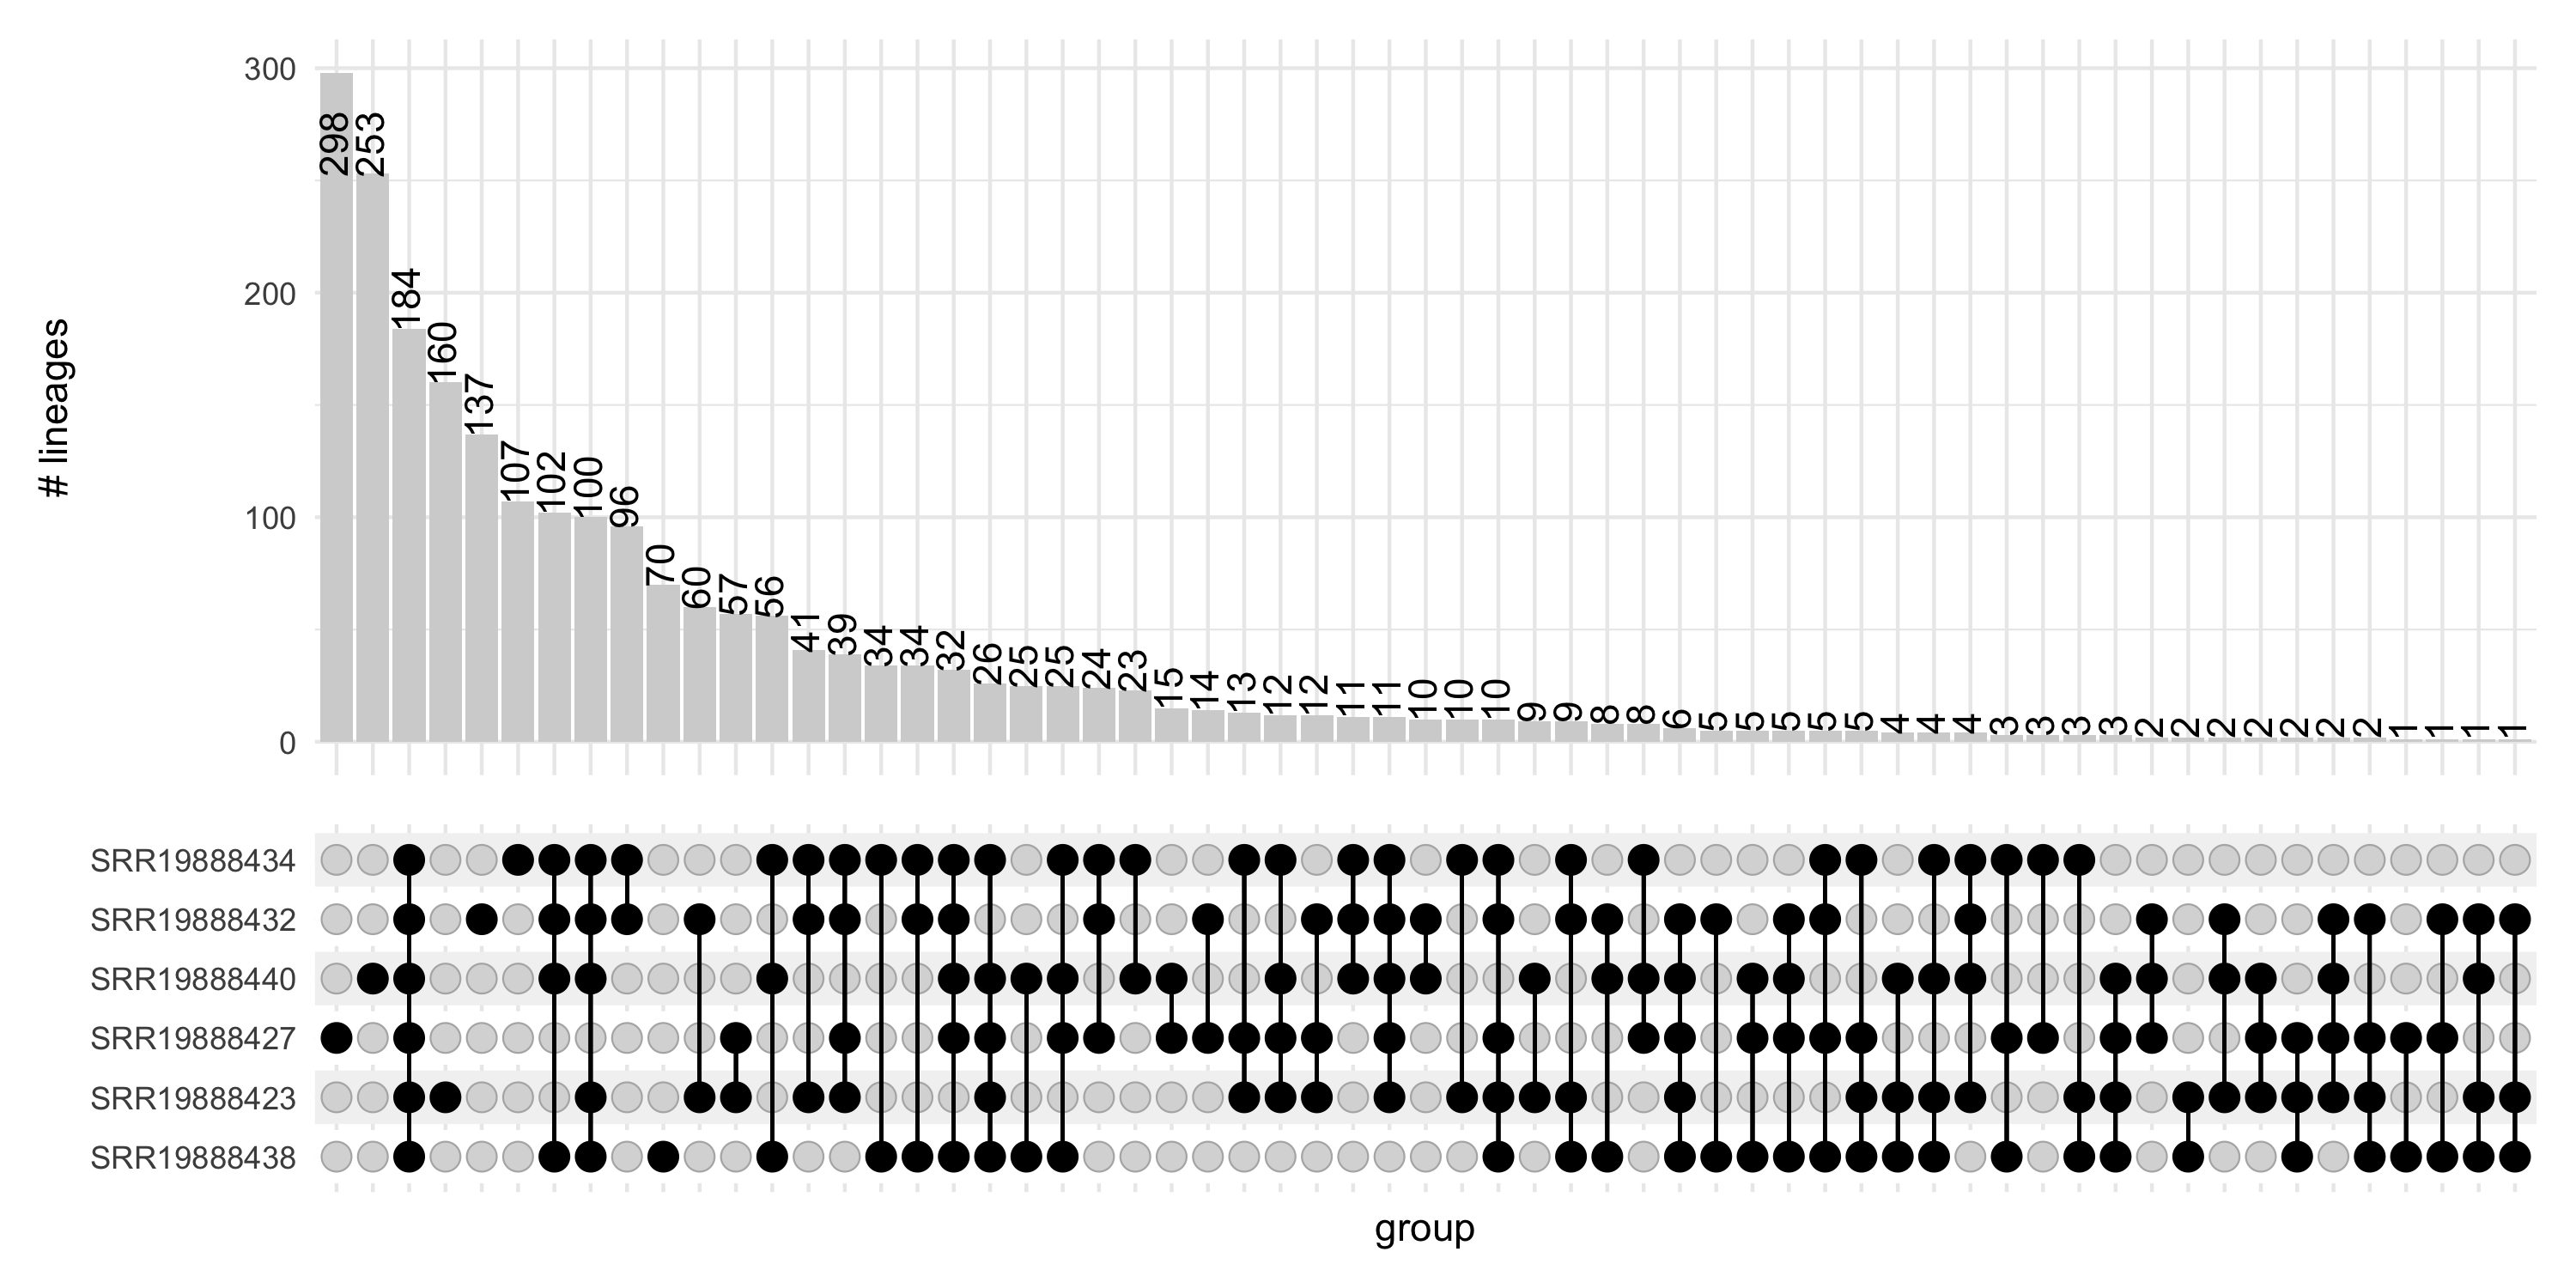

In [26]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

# plot the upset plot
upset(upset_list, intersect = names(sourmash_taxonomy_list), set_sizes = F, 
      base_annotations=list(
          '# lineages'=intersection_size(text=list(vjust=0.4, hjust=.05, angle=90), 
                                                          text_colors=c(on_background='black', on_bar='black'),
                                                          mapping=aes(fill='bars_color')) + 
           scale_fill_manual(values=c('bars_color'='lightgrey'), guide='none'))
     )